## Data Preprocessing
This notebook handles the preprocessing of the dataset that is used to train the model.
<br><br>

### __Dataset Details__
The data consists of labeled images of rocks and minerals organized by their respective types.

There are two sets of data, the [__training data__](#training-data-processing) and the [__testing data__](#test-data-processing). Each set follows the same structure outlined above, with the only difference coming from how the images are preprocessed. <br><br>

#### Resizing
Image size affects a variety of factors when it comes to training a model, but mainly __performance__ and __detail__. Due to rocks and minerals being the target of identification, i'll be training the model with an image size of __256px x 256px__. This will add more detail for the model to train on, which will hopefully translate to improved accuracy when fed sub-optimal images to identify.
<br><br>

***

### Step 1: Splitting dataset
The first step is to split the data into a set for training and a set for testing. This can be done manually, but instead I'm going to utilize scikit-learn's `train_test_split()` method with an 80/20 split (80% used for training and 20% for testing).

In [1]:
import os
from sklearn.model_selection import train_test_split

In [2]:
# Path to the dataset
dataset_path = '.\\wa_spec_dataset'

# Defining 2 arrays to eventually store image paths and labels
image_paths = []
image_labels = []

for folder in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder)

    # Check if folder_path is a directory
    if os.path.isdir(folder_path):
        for subfolder in os.listdir(folder_path):
            subfolder_path = os.path.join(folder_path, subfolder)
            class_name = os.path.basename(os.path.dirname(subfolder)).split('_')[0]

            image_paths.append(subfolder_path)
            image_labels.append(subfolder.split('_')[0])

# Using the train_test_split() method to split the data
X_train, X_test, y_train, y_test = train_test_split(image_paths, image_labels, test_size=0.2, stratify=image_labels, random_state=42)

### Step 2: Processing The Data

In [3]:
# Using PyTorch to preprocess images
from torchvision import transforms, datasets
from PIL import Image
from torch.utils.data import Dataset, DataLoader

#### Defining Transformations
Below I'm defining the transformations to be applied during training, here's a breakdown of each transformation:
- __`.Resize`__ <br>
The model expects a specific size image, so this adjusts the size of each image to match.
<br><br>
- __`.RandomHorizontalFlip` & `.RandomRotation`__ <br>
Both of these functions are used to provide more variety to the small dataset, artificially 'increasing' the size.
<br><br>
- __`.ToTensor`__ <br>
Converts the image to a PyTorch tensor (a multi-dimensional array), scaling the pixel values to a range between 0 and 1 for easier manipulation.
<br><br>
- __`.Normalize`__ <br>
Further scales the pixel values based on the set mean and standard deviation ((val - mean) / standard deviation).

In [4]:
# Const variable for image size
IMAGE_SIZE = 256

processed_training_data = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Essentially the same, but without the augmentation
processed_test_data = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

#### Using DataLoader
DataLoader provides efficient management of the datatset, batch sizes, continuous transformations, shuffling and more. 
- __Batch Sizes__: <br> 
Allows the model to process multiple images at once rather than one by one.
<br><br>
- __Continuous Transformations__: <br>
Upon each epoch, the transformations we defined above will be reapplied to each image meaning the model will be seeing the same images but with slight variation each time.
<br><br>
- __Shuffling__: <br>
Exactly as it sounds, the data is shuffled each time.

In [68]:
# Const variable for batch size
BATCH_SIZE = 5

class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label

# Creating dataset instances, using the appropriate transformations defined above.
train_dataset = CustomDataset(X_train, y_train, transform = processed_training_data)
test_dataset = CustomDataset(X_test, y_test, transform = processed_test_data)


# Creating seperate data loaders for training and testing data
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

#### Model, Loss Function & Optimizer
- __Model__: <br>
Convolutional Neural Network
<br><br>
- __Loss Function__: <br>
Cross Entropy Loss is best suited for classification tasks, in short it penalizes the model based on it's confidence when making both corrent and incorrect predictions.
<br><br>
- __Optimizer__: <br>
Based on what I've read, `Adam` seems to be the recommended optimizer for classification tasks. However, due to my dataset being limited, another option I'm going to explore is `Adagrad`.


In [84]:
# Importing the cnn
from rockhound_cnn import RockHoundCNN
import torch
import torch.nn as nn
import torch.optim as optim

LEARNING_RATE = 0.001

# Initialize model, loss function, and optimizer
num_classes = len(set(image_labels))
model = RockHoundCNN(num_classes)

# loss function (predicted vs actual)
lossFunc = nn.CrossEntropyLoss()

# Going to test multiple optimizers
# Adam, Adagrad
optimizer_adam = optim.Adam(model.parameters(), lr=LEARNING_RATE)
optimizer_adagrad = optim.Adagrad(model.parameters(), lr=0.001, lr_decay=0, weight_decay=0)

# Move model to GPU if available
# Improves performance
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

RockHoundCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=262144, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)

In [85]:
import csv
import pandas as pd

with open('./results/training_results.csv', mode='w', newline='') as file:
    output = csv.writer(file)
    output.writerow(["epoch", "training_loss"])

    # Create a label mapping
    label_map = {'chalcedony': 0, 'jasper': 1, 'petrifiedwood': 2, 'quartz': 3}

    # Num of runs through training data
    num_epochs = 10

    for epoch in range(num_epochs):
        # Set the model to training mode
        model.train()  
        running_loss = 0.0
        
        for data in train_loader:
            images = data[0].to(device)

            # Convert labels to numeric using the label mapping
            numeric_labels = [label_map[label] for label in data[1]] 
            labels = torch.tensor(numeric_labels, dtype=torch.long).to(device)
            
            # Zero the parameter gradients
            optimizer_adam.zero_grad()
            
            # Forward pass
            outputs = model(images)
            loss = lossFunc(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer_adam.step()
            
            running_loss += loss.item()

            training_loss = running_loss / len(train_loader)
            
        output.writerow([epoch + 1, f"{training_loss:.4f}"])
        # Print loss for the epoch
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

Epoch [1/10], Loss: 3.5323
Epoch [2/10], Loss: 1.1663
Epoch [3/10], Loss: 0.8868
Epoch [4/10], Loss: 0.6643
Epoch [5/10], Loss: 0.3100
Epoch [6/10], Loss: 0.3820
Epoch [7/10], Loss: 0.2174
Epoch [8/10], Loss: 0.0755
Epoch [9/10], Loss: 0.0817
Epoch [10/10], Loss: 0.0281


In [86]:
model.eval()
correct = 0
total = 0

# Create the label mapping for evaluation
label_map = {'chalcedony': 0, 'jasper': 1, 'petrifiedwood': 2, 'quartz': 3}

with torch.no_grad():
    for data in test_loader:
        images = data[0].to(device)  # Move images to the device
        
        # Convert labels to numeric using the label mapping
        # Assuming data[1] is a list of labels
        numeric_labels = [label_map[label] for label in data[1]]
        
        # Create tensor from numeric labels
        labels = torch.tensor(numeric_labels, dtype=torch.long).to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Print the accuracy
accuracy = 100 * correct / total if total > 0 else 0  # Avoid division by zero
print(f'Test data model accuracy: {accuracy:.2f}%')

df = pd.read_csv('./results/training_results.csv')
df

Test data model accuracy: 62.50%


,epoch,training_loss
0,1,3.5323
1,2,1.1663
2,3,0.8868
3,4,0.6643
4,5,0.3100
5,6,0.3820
6,7,0.2174
7,8,0.0755
8,9,0.0817
9,10,0.0281


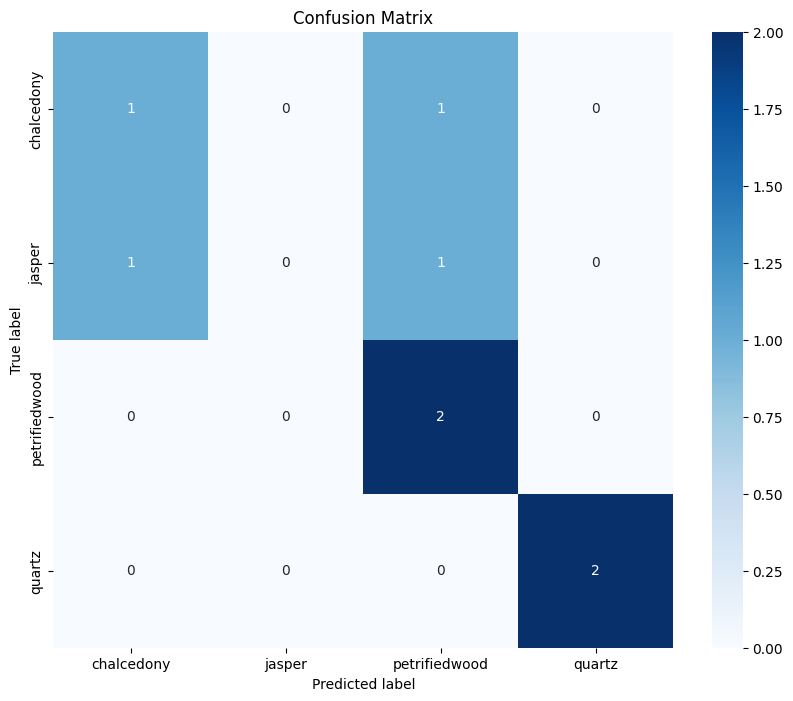

In [87]:
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure the model is in evaluation mode
model.eval()

all_predictions = []
all_labels = []

# Define your label mapping (ensure this is correct)
label_map = {
    'chalcedony': 0,
    'jasper': 1,
    'petrifiedwood': 2,
    'quartz': 3
}

# No gradient computation during evaluation
with torch.no_grad():
    for data in test_loader:
        images = data[0].to(device)
        labels = data[1]

        # Convert labels to indices
        numeric_labels = [label_map[label] for label in labels]
        labels_tensor = torch.tensor(numeric_labels, dtype=torch.long).to(device)

        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # Collect predictions and labels
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels_tensor.cpu().numpy())


# Create confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.show()

# Class names corresponding to your labels
class_names = ['chalcedony', 'jasper', 'petrifiedwood', 'quartz']

# Plot the confusion matrix
plot_confusion_matrix(cm, class_names)

